# **An introduction to Deep Inverse**

# Setting Up Deep Inverse
Install the library


In [1]:
import deepinv as dinv
import torch
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from deepinv.utils.demo import load_dataset, load_degradation, get_image_dataset_url, load_image

/home/samuel/Documents/deepinv/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load an image $x$ and display it

Selected GPU 0 with 3903 MB free memory 


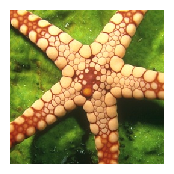

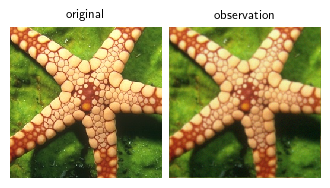

In [2]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
x = load_image('datasets/set3c/0/starfish.png', img_size = 256, device=device)

dinv.utils.plot([x])


from pathlib import Path
BASE_DIR = Path(".")
ORIGINAL_DATA_DIR = BASE_DIR / "datasets"
DATA_DIR = BASE_DIR / "measurements"
RESULTS_DIR = BASE_DIR / "results"
DEG_DIR = BASE_DIR / "degradations"

# operator = dinv.physics.Inpainting(tensor_size=x.shape[1:], mask=.5, noise_model=dinv.physics.GaussianNoise(sigma=sigma), device=device)
# operator = dinv.physics.Downsampling(x.shape, noise_model=dinv.physics.GaussianNoise(sigma=sigma), device=device) # try changing the operator!
kernel_index = 2
kernel_torch = load_degradation(
    "kernels_12.npy", DEG_DIR / "kernels", index=kernel_index
)
kernel_torch = kernel_torch.unsqueeze(0).unsqueeze(
    0
)  # add batch and channel dimensions
sigma = 0.01
operator = dinv.physics.BlurFFT(x.shape, noise_model=dinv.physics.GaussianNoise(sigma=sigma), filter=dinv.physics.blur.gaussian_blur(), device=device)

y = operator(x)

dinv.utils.plot([x,y], titles=['original','observation'])

# Solving Inverse Problems with Deep Inverse

In [44]:
data_fidelity = dinv.optim.data_fidelity.L2()

from deepinv.optim.prior import RED
from deepinv.utils.parameters import get_GSPnP_params
from deepinv.optim.optimizers import optim_builder

class GSPnP(RED):
    r"""
    Gradient-Step Denoiser prior.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.explicit_prior = True

    def g(self, x, *args, **kwargs):
        r"""
        Computes the prior :math:`g(x)`.

        :param torch.tensor x: Variable :math:`x` at which the prior is computed.
        :return: (torch.tensor) prior :math:`g(x)`.
        """
        return self.denoiser.potential(x, *args, **kwargs)

prior = GSPnP(
    denoiser=dinv.models.GSDRUNet(pretrained="download", train=False).to(device)
)

operation = "deblur"

lamb, sigma_denoiser, stepsize, max_iter = get_GSPnP_params(operation, sigma)

params_algo = {
    "stepsize": stepsize,
    "g_param": sigma_denoiser,
    "lambda": lamb,
}

thres_conv = 1e-5


# we want to output the intermediate PGD update to finish with a denoising step.
def custom_output(X):
    return X["est"][1]


model = optim_builder(
    iteration="PGD",
    prior=prior,
    g_first=True,
    data_fidelity=data_fidelity,
    params_algo=params_algo,
    early_stop=False,
    crit_conv='cost',
    thres_conv=thres_conv,
    backtracking=True,
    get_output=custom_output,
    verbose=True,
    max_iter=60,
)


In [45]:
with torch.no_grad():
    xhat, metrics = model(y, operator, x_gt=x, compute_metrics=True)

/tmp/ipykernel_8594/1055177233.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_8594/1055177233.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


[]

<Figure size 640x480 with 0 Axes>

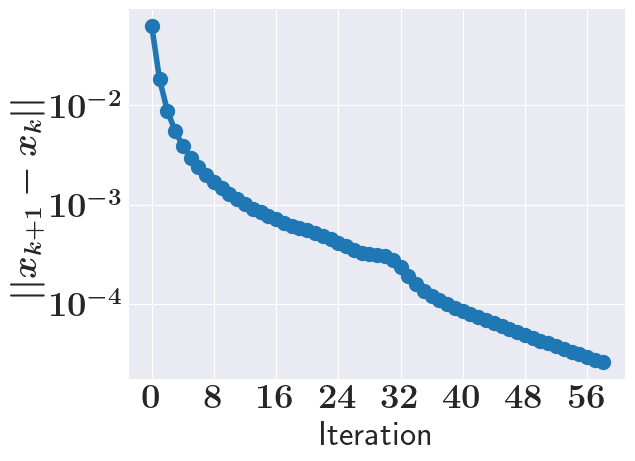

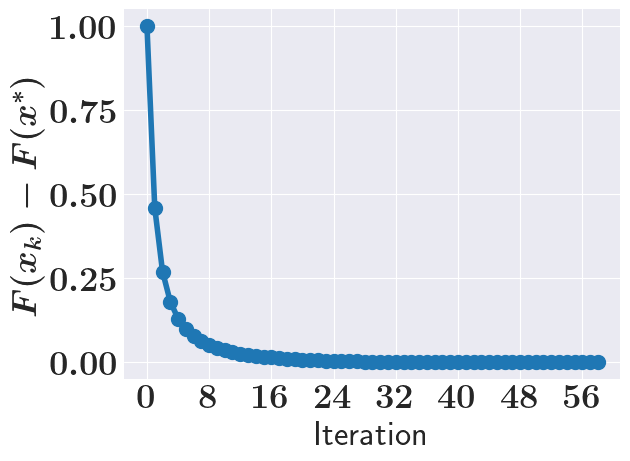

In [59]:
psnr = metrics['psnr']
res = metrics['residual']
cost = metrics['cost']
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 10
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \boldmath'

matplotlib.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['text.usetex'] = True

plt.figure(0)
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.semilogy(res[0][1:], '-o')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel(r'$||x_{k+1}-x_k||$')
plt.plot()


plt.figure(1)
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot((np.array(cost[0][1:]) - np.array(cost[0][-1])) / (cost[0][1] - cost[0][-1]) , '-o')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel(r'$F(x_k) - F(x^*)$')
plt.plot()